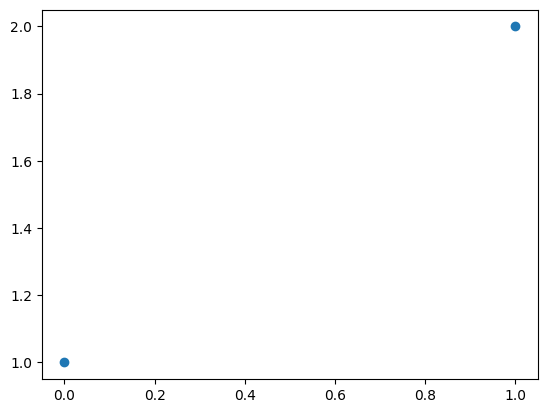

In [2]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
Style_A
1.5741465383079042e-05


TypeError: prep_run() missing 1 required positional argument: 'i_source'

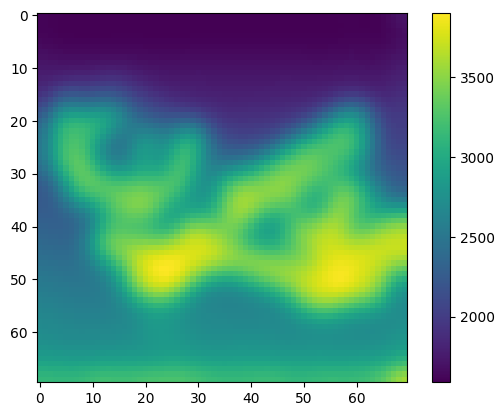

In [3]:
importlib.reload(kgs)
importlib.reload(seis_test)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[-1001]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])
import seis_test
seis_test.test_stuff_on_one_case(d,1e-4)
d.load_to_memory()

In [7]:
kgs.profiling=False
d.load_to_memory()
seis_base_recalc = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
vel_offset_vector = 0.1*cp.array(np.random.default_rng(seed=0).normal(0,1,(4901,1)), dtype=kgs.base_type_gpu)
vel_modified = copy.deepcopy(d.velocity)
vel_modified.from_vector(d.velocity.to_vector() + vel_offset_vector[:,0])
seis_modified = seis_forward.vel_to_seis(vel_modified, d.seismogram)[0]
seis_modified_vector = seis_modified.to_vector()
#seis_modified_linear = copy.deepcopy(d.seismogram)
#seis_modified_linear.from_vector(seis_base_recalc.to_vector() + matmul_part_cpu(J,vel_offset_vector)[:,0])
#kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)), kgs.rms(seis_modified_vector - seis_base_recalc.to_vector())
#print(matmul_part_cpu(J,vel_offset_vector).shape)
#print(matmul_part_cpu(J,vel_offset_vector).shape)
#print(kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - matmul_part_cpu(J,vel_offset_vector)[:,0]),kgs.rms(seis_modified_vector - seis_base_recalc.to_vector()))
#print(kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - matmul_part_cpu(J,vel_offset_vector)[:,0])/kgs.rms(seis_modified_vector - seis_base_recalc.to_vector()))
print(kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)[0,:] ),kgs.rms(seis_modified_vector - seis_base_recalc.to_vector()))
print(kgs.rms(seis_modified_vector - seis_base_recalc.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)[0,:] )/kgs.rms(seis_modified_vector - seis_base_recalc.to_vector()))

#print(kgs.rms(vel_offset_vector), kgs.rms(seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)[0,:]), kgs.rms(matmul_part_cpu(J,vel_offset_vector)[0,:]))


# kgs.profiling=False
# seis_base = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
# vel_offset_vector = 0.01*cp.array(np.random.default_rng(seed=0).normal(0,1,(4901,1)), dtype=kgs.base_type_gpu)
# vel_modified = copy.deepcopy(d.velocity)
# vel_modified.from_vector(d.velocity.to_vector() + vel_offset_vector[:,0])
# seis_modified = seis_forward.vel_to_seis(vel_modified, d.seismogram)[0]
# seis_modified_vector = seis_modified.to_vector()
# assert J.flags.c_contiguous
# #kgs.rms(seis_modified_vector - seis_base.to_vector() - seis_forward.vel_to_seis_diff(d.velocity, vel_offset_vector.T)), kgs.rms(seis_modified_vector - seis_base.to_vector())
# kgs.rms(seis_modified_vector - seis_base.to_vector() - (matmul_part_cpu(J,vel_offset_vector))[:,0]), kgs.rms(seis_modified_vector - seis_base.to_vector())

1.1902333927717919e-07 0.00014479986989544009
0.000821985125836963


In [25]:
kgs.rms(seis_base_recalc.data - d.seismogram.data)

array(1.57414654e-05)

In [26]:
P=cp.eye(J.shape[1], dtype=cp.float64)
# PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=-1)+cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-2*cp.eye(J_basis.shape[1])
# PP = PP[1:-1,:]
# PP=cp.diag(1*np.ones(J_basis.shape[1]-1),k=1)-1*cp.eye(J_basis.shape[1])
# PP = PP[:-1,:]
# PP = PP.T@PP
# #print(PP.shape)
# #plt.imshow(cp.asnumpy(PP))
# P = PP
def analyze_one(velocity_guess, velocity_true, seismogram_for_guess, seismogram_true_given, lambda_vals):
    print('starting')
    s0 = seismogram_true_given.to_vector()[:,None]
    s1 = seismogram_for_guess.to_vector()[:,None]
    v1 = velocity_guess.to_vector()[:,None]
    v_base = v1

    res = []
    v0_list = []
    rhs_part = matmul_part_cpu(J.T,(s0-s1))
    #return
    for lam in lambda_vals:
        rhs=rhs_part-lam*v1
        delta_v = cp.linalg.solve(lam*P+JTJ,rhs)
        v0 = v1+delta_v
        v0_list.append(v0)
        res.append(kgs.rms(v0-velocity_true.to_vector()[:,None]))
        
            
        #print(lam,penalty(v0),penalty(velocity_true.to_vector()[:,None]))

    return cp.asnumpy(cp.array(res)), v0_list

In [ ]:
# So we get access to vel_modified (and seis_modified) and seis_base_recalc, and are asked to reconstruct vel_base.
lambda_vals = 10**np.linspace(-17,-6,15)

res1,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, lambda_vals)
res2,v0_list = analyze_one(vel_modified, d.velocity, seis_modified_linear, seis_base_recalc, lambda_vals)
res3,v0_list = analyze_one(d.velocity, d.velocity, seis_base_recalc, seis_base_recalc, lambda_vals)
res4,v0_list = analyze_one(d.velocity, d.velocity,seis_base_recalc, d.seismogram, lambda_vals)
#res4,v0_list = analyze_one(vel_modified, d.velocity, seis_modified, seis_base_recalc, J_basis, lambda_vals)

# #lambda_vals = [1e-6]
# res=[]
# v0_list=[]
# rhs_part = J_basis.T@(s0-s1)
# for lam in lambda_vals:
#     rhs=rhs_part-lam*v_base
#     delta_v = cp.linalg.solve(lam*cp.eye(J_basis.shape[1], dtype=J_basis.dtype)+J_basis.T@J_basis,rhs)
#     v0 = v1+basis_vectors@delta_v
#     v0_list.append(v0)
#     res.append(kgs.rms(v0-d.velocity.to_vector()[:,None]))
# res = cp.asnumpy(cp.array(res))
plt.loglog(lambda_vals,res1)
plt.loglog(lambda_vals,res2,linewidth=3)
plt.loglog(lambda_vals,res3)
plt.loglog(lambda_vals,res4)
plt.grid(True)
plt.title('Regularize total')
plt.legend(('Initial guess: vel_modified, base seismogram: seis_base_recalc', 'LIN: Initial guess: vel_modified, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: seis_base_recalc', 'Initial guess: d.velocity, base seismogram: d.seismogram'))

starting
starting
starting
starting


[[3.65090177e+10]] 3.751102805280306e-05
[[3.65043841e+10]] 1.5741465383079042e-05


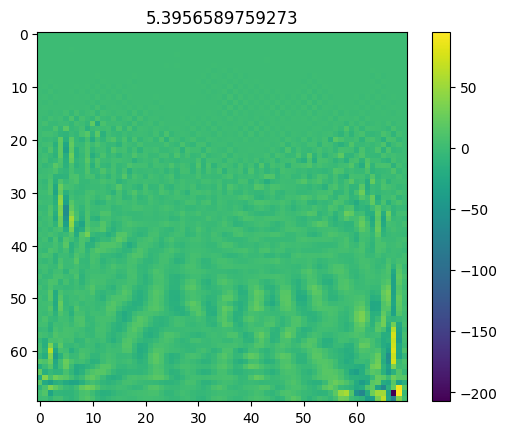

In [23]:
def show_penalty(v):    
    vel_new = copy.deepcopy(d.velocity)
    vel_new.from_vector(v[:,0])
    seis = seis_forward.vel_to_seis(vel_new, d.seismogram)[0]
    res = (seis.to_vector()[:,None]-d.seismogram.to_vector()[:,None])
    #penalty = (lam*v.T@v + res.T@res)[0,0]
    #v_base = cp.linalg.solve(basis_vectors.T@basis_vectors, basis_vectors.T@v)
    print(v.T@P@v, kgs.rms(res))
    #return penalty
    
to_take = np.argmin(res4)
v0 = v0_list[to_take]
plt.figure()
vel_new = copy.deepcopy(d.velocity)
vel_new.from_vector(v0[:,0])
plt.title(cp.mean(cp.abs(vel_new.data-d.velocity.data)))
plt.imshow(cp.asnumpy(vel_new.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
show_penalty(v0)
show_penalty(d.velocity.to_vector()[:,None])
#plt.figure()
#plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])
#plt.figure()
#plt.imshow(cp.asnumpy(vel_new.data));plt.colorbar();#plt.clim([-3,3])
#plt.figure()
#plt.title(cp.mean(cp.abs(vel_modified.data-d.velocity.data)))
#plt.imshow(cp.asnumpy(vel_modified.data-d.velocity.data));plt.colorbar();#plt.clim([-3,3])
#print(kgs.rms(seis_modified.data-seis_base_recalc.data), kgs.rms(d.seismogram.data-seis_base_recalc.data))
#print(kgs.rms(vel_modified.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_modified, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))
#print(kgs.rms(vel_new.data-d.velocity.data), kgs.rms(seis_forward.vel_to_seis(vel_new, d.seismogram)[0].data-seis_forward.vel_to_seis(d.velocity, d.seismogram)[0].data))